In [1]:
# https://quantumcomputing.stackexchange.com/questions/24050/how-to-implement-a-exponential-of-a-hamiltonian-but-non-unitary-matrix-in-qisk

# control gate: https://qiskit.org/documentation/stubs/qiskit.circuit.ControlledGate.html

# circuit https://www.nature.com/articles/s41598-022-17660-8
import numpy as np

from qiskit.circuit import ControlledGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.tools.visualization import plot_histogram

from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import Operator

In [2]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow.list_ops import SummedOp
from qiskit.circuit import Parameter
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp
A = np.array([
    [11, 5, -1, -1],
    [5, 11, 1, 1],
    [-1, 1, 11, -5],
    [-1, 1, -5, 11],
    ]).astype('complex')

b = np.array([0, 0, 0, 1]).T

In [3]:
def get_gate(A, n):    
    pauli_op = PauliSumOp(SparsePauliOp.from_operator(A))
    phi = Parameter('ϕ')
    evolution_op = (phi * pauli_op).exp_i() # exp(-iϕA)
    trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evolution_op).bind_parameters({phi: np.pi/n})
    #----control---------
    gate = trotterized_op.to_circuit()
    # print(gate)
    gate.name = f"e^(i*A*pi/{n})"
    gate.label = f"e^(i*A*np.pi/{n})"
    gate = gate.to_gate().control()
    #---------------------
    return gate

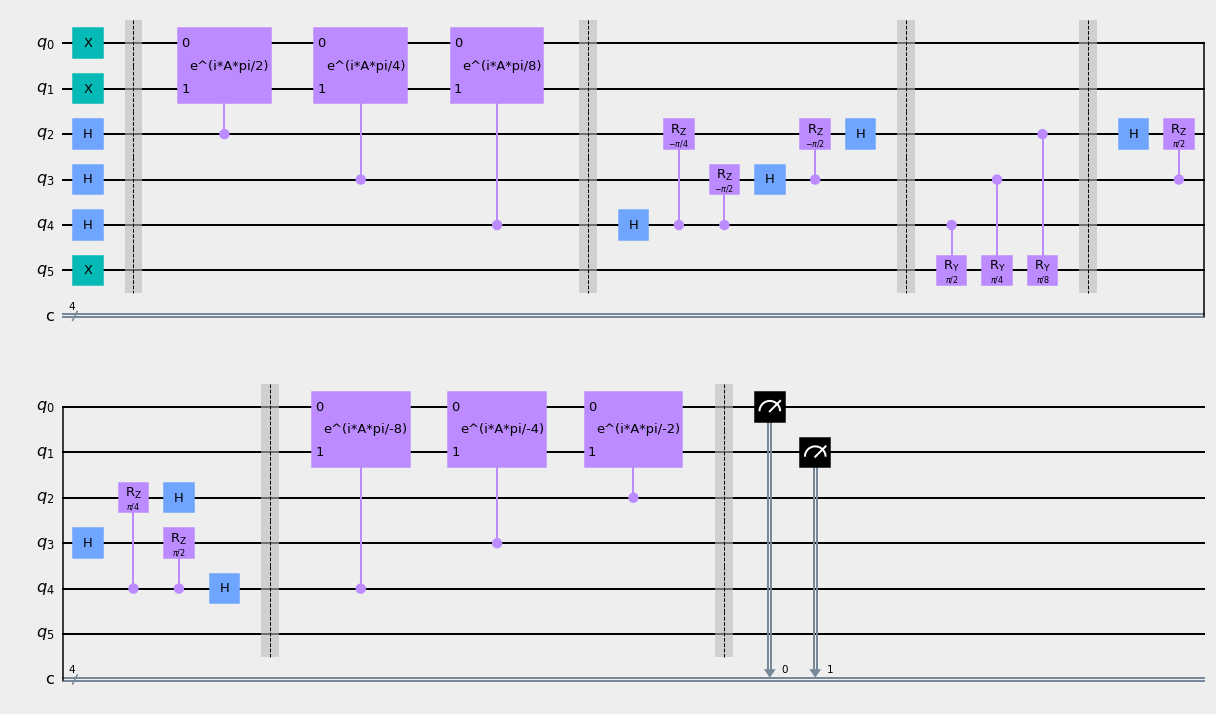

In [112]:
n_b = 2
n_ = 3
n_ancilla = 1
n_cl = 4
# quantum circuit initialization
qc = QuantumCircuit(n_b + n_ + n_ancilla, n_cl)
# b-vector state preparation
for i in range(n_b):
    qc.x(i)
for i in range(n_b, n_b+n_):
    qc.h(i)
qc.x(-1)
qc.barrier()
# Matrix exponentiation
for i in range(1, n_+1):
    gate = get_gate(A, 2**(i))
    qc.append(gate,[i+1, 0, 1])
qc.barrier()
# Phase estimation
for j in range(n_b + n_ - 1, n_b, -1):
    qc.h(j)
    for m in range(j - n_b):
        qc.crz(-np.pi/float(2**(j-m - n_b)), j, m+n_b)
qc.h(j-1)
qc.barrier()
# As I understood, we wncode ancilla qubit to be sure that result will be correct
for j in range(1, 1+n_):
    qc.cry(np.pi/(2**j), n_b+n_-j, n_b+n_)
qc.barrier()
# Inverse quantum Fourier transform
for j in range(n_b, n_b + n_):
    for m in range(j - n_b):
        qc.crz(np.pi/float(2**(j-m - n_b)), j, m+n_b)
    qc.h(j)
qc.h(n_b)
qc.barrier()
# Eigenvalues storing in the vecor b register
for i in range(n_, 0, -1):
    gate = get_gate(A, -(2**(i)))
    qc.append(gate,[i+1, 0, 1], )
qc.barrier()
# qubits measurement. I do not measure the ancilla qubit
# qc.measure(-1, 2)
qc.measure(0, 0)
qc.measure(1, 1)

qc.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})

In [113]:
simulator = Aer.get_backend('qasm_simulator')
circ = transpile(qc, simulator)
shots = 2048
result = execute(qc, backend=simulator, shots=shots).result()

# Calculated result

In [114]:
counts = result.get_counts()
probabilities = counts.copy()
for k, v in probabilities.items():
    probabilities[k] = v/shots
probabilities

{'0010': 0.20751953125,
 '0011': 0.7431640625,
 '0000': 0.02880859375,
 '0001': 0.0205078125}

# Result vector

In [115]:
vect = np.array([v for k,v in probabilities.items()])
vect.sort()
vect

array([0.02050781, 0.02880859, 0.20751953, 0.74316406])

# Real normalized result

In [116]:
a = [0.03125, -0.03125, 0.0625, 0.125]

from sklearn.preprocessing import normalize
real_x_norm = (np.array(a) / np.linalg.norm(a))**2
real_x_norm.sort()
real_x_norm

array([0.04545455, 0.04545455, 0.18181818, 0.72727273])

# Error

In [117]:
mse = (np.square(vect - real_x_norm)).mean()

In [118]:
mse

0.00045313027279436185